# Description
## Project Summaries
This is an [Kaggle competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/).Personally, I use this project to learn a powerful python Timeseries package Darts which presents a better performance in Time series predictions. Here are some summaries of the project
* **Baseline:** Linear regression to every single series generates a  baseline forecast - RMSLE: 0.68759
* **Goal:** Leverage large amount of timeseries data via global models(boosted trees)
* **Best model**: 
    ** 2024-07-26 with RMSLE as 0.38816 -> #56 out of 803(Top 7%, 20240726) in leaderboard
    - Ensemble 33(family)*4(lags)*2(time slots data) LightGBM models, one for each product family, each trained on 54 timeseries(or stores)
    - 4 lags are 7, 63, 365, 730 with past_covariate_lags(range(-16,-23,-1)) for all lags, future_covariate_lags(14,1) for 63,365, and 730. future_covariate_lags(16,1) for 7    
    - 2 time slots are whole data and partial data(>=20150101)
* Key factors that improve the model performance:
    * feature engineering of the date realted feature and lags
    * lags, future covariate lags, past covariate lag setting
* Next steps:
    * Tune hyperparameters of the xgb models
    * Dedicated models for the worst prodcut predictions



## Project Backgroud
 The competition goal is to use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. This project needs to build a model(models) that predicts the unit sales for 33 product families at 54 stores. The train sales data is from 2013-01-01 to 2017-08-15 and test data is from 2017-08-16 to 2017-08-31.   

## Data description
The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. 
* train.csv The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
    * store_nbr identifies the store at which the products are sold.
    * family identifies the type of product sold.
    * sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
    * onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
* test.csv The test data, having the same features as the training data. The dates in the test data are for the 15 days after the last date in the training data.

* holidays_events.csv Holidays and Events, with metadata. NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

* Additional Notes Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this. A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.


# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import (
    MissingValuesFiller,
    Scaler,
    InvertibleMapper,
    StaticCovariatesTransformer)
from darts.metrics.metrics import mape,rmsle
from darts.models import ExponentialSmoothing, XGBModel,LinearRegressionModel,LightGBMModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Import data
Import datasets and have a quick view of each dataset.

In [2]:
DATA_PATH = Path()/'dataset/'
SUBMISSION_PAHT = Path()/'submission/'

In [3]:
def df_brief(df, df_name, need_unique_values= False, unique_cols=[]):
    '''
    Briefly show the data info of a dataframe. 
    Also shows all unique value of each assigned columns 
    if there is a requirement of showing the unique values.
    '''
    print(f'The {df_name} shape is {df.shape}')
    display(df.head())
    display(df.info())
    if any(df.dtypes=='object'):
        display('Categorical columns:')
        display(df.describe(include='O'))
    display(df.describe())
    
    if need_unique_values:
        for col in unique_cols:
            print(f'{col} has {df[col].nunique()} unique values. They are \n{sorted(df[col].unique())}')

## Train

In [4]:
train_data = pd.read_csv(DATA_PATH/'train.csv', parse_dates=['date'])

train_data['store_nbr'] = train_data['store_nbr'].astype('object')
df_brief(train_data, 'Train', need_unique_values= True, unique_cols= ['store_nbr','family'])

The Train shape is (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    object        
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 137.4+ MB


None

'Categorical columns:'

,store_nbr,family
count,3000888,3000888
unique,54,33
top,1,AUTOMOTIVE
freq,55572,90936


,id,date,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.101998e+03,1.221888e+01


store_nbr has 54 unique values. They are 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
family has 33 unique values. They are 
['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']


Train data includes 33 product families covering 54 stores, spanning 3,000,888 sales records from 2013-01-01 to 2017-08-15  

## Test

In [5]:
test_data = pd.read_csv(DATA_PATH/'test.csv', parse_dates=['date'])
test_data['store_nbr'] = test_data['store_nbr'].astype('object')
df_brief(test_data, 'Test data')

The Test data shape is (28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  object        
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.1+ MB


None

'Categorical columns:'

,store_nbr,family
count,28512,28512
unique,54,33
top,1,AUTOMOTIVE
freq,528,864


,id,date,onpromotion
count,2.851200e+04,28512,28512.000000
mean,3.015144e+06,2017-08-23 12:00:00,6.965383
min,3.000888e+06,2017-08-16 00:00:00,0.000000
25%,3.008016e+06,2017-08-19 18:00:00,0.000000
50%,3.015144e+06,2017-08-23 12:00:00,0.000000
75%,3.022271e+06,2017-08-27 06:00:00,6.000000
max,3.029399e+06,2017-08-31 00:00:00,646.000000
std,8.230850e+03,NaN,20.683952


Test data contains 28,512 records(33 products * 54 store * 16 days) which are from 2017-08-16 to 2017-08-31 

## Transaction

In [6]:
transactions = pd.read_csv(DATA_PATH/'transactions.csv', parse_dates=['date'])
transactions['store_nbr'] = transactions['store_nbr'].astype('O')
df_brief(transactions,'Transaction data')


The Transaction data shape is (83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  object        
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ MB


None

'Categorical columns:'

,store_nbr
count,83488
unique,54
top,39
freq,1678


,date,transactions
count,83488,83488.000000
mean,2015-05-20 16:07:40.866232064,1694.602158
min,2013-01-01 00:00:00,5.000000
25%,2014-03-27 00:00:00,1046.000000
50%,2015-06-08 00:00:00,1393.000000
75%,2016-07-14 06:00:00,2079.000000
max,2017-08-15 00:00:00,8359.000000
std,NaN,963.286644


Transaction data's unit is store. i.e. one transaction per store per day. 84,388 data is spanning from 2013-01-01 to 2017-08-15(1687 days). There should exists missing data in transaction since 1687*54=91,098

## Store

In [7]:
stores_data = pd.read_csv(DATA_PATH/'stores.csv')
stores_data[['store_nbr','cluster']] = stores_data[['store_nbr','cluster']].astype('O')
df_brief(stores_data, 'Store data', need_unique_values= True, unique_cols=['city','state','type','cluster'])

The Store data shape is (54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     object
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     object
dtypes: object(5)
memory usage: 2.2+ KB


None

'Categorical columns:'

,store_nbr,city,state,type,cluster
count,54,54,54,54,54
unique,54,22,16,5,17
top,1,Quito,Pichincha,D,3
freq,1,18,19,18,7


,store_nbr,city,state,type,cluster
count,54,54,54,54,54
unique,54,22,16,5,17
top,1,Quito,Pichincha,D,3
freq,1,18,19,18,7


city has 22 unique values. They are 
['Ambato', 'Babahoyo', 'Cayambe', 'Cuenca', 'Daule', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Playas', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']
state has 16 unique values. They are 
['Azuay', 'Bolivar', 'Chimborazo', 'Cotopaxi', 'El Oro', 'Esmeraldas', 'Guayas', 'Imbabura', 'Loja', 'Los Rios', 'Manabi', 'Pastaza', 'Pichincha', 'Santa Elena', 'Santo Domingo de los Tsachilas', 'Tungurahua']
type has 5 unique values. They are 
['A', 'B', 'C', 'D', 'E']
cluster has 17 unique values. They are 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


Store data contains 54 unique stores, which are divided into 17 clusters, 5 types, 22 cities, and 16 states.

## Oil

In [8]:
oil = pd.read_csv(DATA_PATH/'oil.csv', parse_dates=['date'])
oil = oil.rename(columns={'dcoilwtico':'oil'})
df_brief(oil, 'oil data')

The oil data shape is (1218, 2)


,date,oil
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1218 non-null   datetime64[ns]
 1   oil     1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


None

,date,oil
count,1218,1175.000000
mean,2015-05-02 12:00:00,67.714366
min,2013-01-01 00:00:00,26.190000
25%,2014-03-03 06:00:00,46.405000
50%,2015-05-02 12:00:00,53.190000
75%,2016-06-30 18:00:00,95.660000
max,2017-08-31 00:00:00,110.620000
std,NaN,25.630476


Oil data is from 2013-01-01 to 2017-08-31 which spans both train and test data time periods

## Holidays

In [9]:
holidays_data = pd.read_csv(DATA_PATH/'holidays_events.csv', parse_dates=['date'])
df_brief(holidays_data,'Holidays event data',need_unique_values= True, unique_cols=['type','locale','locale_name'])

The Holidays event data shape is (350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


None

'Categorical columns:'

,type,locale,locale_name,description
count,350,350,350,350
unique,6,3,24,103
top,Holiday,National,Ecuador,Carnaval
freq,221,174,174,10


,date
count,350
mean,2015-04-24 00:45:15.428571392
min,2012-03-02 00:00:00
25%,2013-12-23 06:00:00
50%,2015-06-08 00:00:00
75%,2016-07-03 00:00:00
max,2017-12-26 00:00:00


type has 6 unique values. They are 
['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day']
locale has 3 unique values. They are 
['Local', 'National', 'Regional']
locale_name has 24 unique values. They are 
['Ambato', 'Cayambe', 'Cotopaxi', 'Cuenca', 'Ecuador', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Imbabura', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santa Elena', 'Santo Domingo', 'Santo Domingo de los Tsachilas']


In [10]:
holidays_data.groupby(['locale','type']).date.count().sort_values(ascending=False)

locale    type      
Local     Holiday       137
National  Holiday        60
          Event          56
          Additional     40
Regional  Holiday        24
Local     Additional     11
National  Transfer        8
          Bridge          5
          Work Day        5
Local     Transfer        4
Name: date, dtype: int64

Holiday data is from 2012 to 2017. There are 350 holidays in total.
The most common type local holiday, followed by National holiday and event


## Submission sample


In [11]:
submission_sample = pd.read_csv(DATA_PATH/'sample_submission.csv')
submission_sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


# Data processing
* Create functions to get pipeline and combined moving average 
* Create Main Timeseries
* Create Future covariates
    * Holidays
    * Date realted
    * Oil
    * Promotion
* Create Past covarites
* Create Darts Static Covariates
* * Create Darts Time-based covariates, adding 7-day, 28-day moving average
* All covariates get stacked together

In [12]:
# function: get_pipeline() which includes missing data filler, one hot encoder(optional), min_max_normalizer, log transformer(optional)
# function: get_pipeline() which inclues missing data filler, one hot encoder(optional), min_max_normalizer, log transformer(optional)
def get_pipeline(stat_cov_trans=False,log_trans=False):
    '''
    This contains
    missing data filler, one hot encoder(optional), min_max_normalizer, log transformer(optional)
    return a pipeline

    Parameters
    ----------
    stat_cov_trans : bool, optional
        If True, it will include the one hot encoder for the static covariates. The default is False.
    log_trans : bool, optional
        If True, it will include the log1p transformer for the target. The default is False.

    Returns
    -------
    pipe : darts.dataprocessing.pipeline.Pipeline   
    '''
    transformer_list =[]
    missing_filler = MissingValuesFiller(n_jobs=-1, verbose= False)
    transformer_list.append(missing_filler)
    # one hot encoding
    if stat_cov_trans:
        static_transformer =StaticCovariatesTransformer(
            transformer_cat= OneHotEncoder(),
            n_jobs=-1
        )
        transformer_list.append(static_transformer)
    
    # This is for the log sales and after prediction, it will automatically inverse the result 
    if log_trans:
        log_transformer = InvertibleMapper(
            fn = np.log1p,
            inverse_fn= np.expm1,
            n_jobs=-1
        )
        transformer_list.append(log_transformer)
        
    # Default is min max scaler
    scaler = Scaler(n_jobs=-1)
    transformer_list.append(scaler)
    
    pipe = Pipeline(transformer_list, verbose=False, n_jobs=-1)
    
    return pipe
    

In [13]:
def get_moving_averages(ts,ts_name, moving_window_list=[7,14]):
    '''
    Building combined moving average ts for ts with windows assigned by window_list
    ts: TimeSeries

    Parameters
    ----------
    ts_name: str, the name of the ts
    moving_window_list: list of int, the window size for moving average

    Returns
    -------
    ts: TimeSeries, the combined moving average ts
    '''
    window_ts_list =[]
    for w in moving_window_list:
        moving_filter =MovingAverageFilter(window=w)
        window_ts = moving_filter.filter(ts)
        # to remove redundancy covariate name
        window_ts = TimeSeries.from_series(window_ts.pd_series())
        window_ts = window_ts.astype(np.float32)
        window_ts = window_ts.with_columns_renamed(col_names=window_ts.components,\
                                                   col_names_new=f'{ts_name}_mov_{w}')
        window_ts_list.append(window_ts)
    
    ts = window_ts_list[0]
    for i in range(1,len(window_ts_list)):
        ts = ts.stack(window_ts_list[i])
    return ts
    
  

## Main Time series data
There are total 54 stores, 33 product faimlies  
Strategies of extracting main time series data could be:
1. Extract all data as a global time series for a general global model. The model can be trained with all data but hard to find the pattern of each store/family
2. Extract time series for each family in each store, there will be total 54*33=1782. The model will only has limited data to train 
3. Create Time series  by store or product family, so there exists the balance between training data amount and model complexisty.  

Here the Timeseries is built by the product families , so there will be 33 Dart TimeSeries data 

In [14]:
# Merge the train data with store data
train_merged= train_data.merge(stores_data, on=['store_nbr'], how='left')
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    object        
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 228.9+ MB


In [15]:

# Predict each product family

def get_main_timeseries(df, family_list, static_col=['city','state','type', 'cluster']):
    '''
    To create the raw main time series dictionary and correlated id_dictionary 
    for the assigned family list.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe which contains the sales data of each product family.
    family_list : list of str
        The list of product family.
    static_col : list of str, optional
        The list of static columns of time series.

    Returns
    -------
    family_ts_dict_raw: dict
        The dictionary of product family and its time series list.
    id_dict: dict
        The dictionary of each product family and corresponding store numbers list.
    '''
    family_ts_dict_raw={}
    id_dict ={}
    for family in tqdm.notebook.tqdm(family_list, desc='Preparing main time series'):
        family_df = df[df.family==family]
        family_ts_list = TimeSeries.from_group_dataframe(
            df = family_df,
            group_cols= ['store_nbr','family'],
            value_cols= 'sales',
            time_col = 'date',
            static_cols = static_col,
            fill_missing_dates=True,
            fillna_value= 0
        )
        for ts in family_ts_list:
            ts = ts.astype(np.float32)

        # The following code is to sort the values according to the store_nbr
        # t.static_covariates:['store_nbr','family','city','state','type', 'cluster']
        # t.static_covariates_values() is like the following:
        # array([['9', 'SCHOOL AND OFFICE SUPPLIES', 'Quito', 'Pichincha', 'B','6']], dtype=object)
        # Sorted function's key parameter is to specify a function (or other callable)
        # to be called on each list element 

        family_ts_list = sorted(family_ts_list, key = lambda t: int(t.static_covariates_values()[0,0]))
        family_ts_dict_raw[family] = family_ts_list
        
        #create id_list for each family: store_nbr list and product family
        id_list =[{'store_nbr':t.static_covariates['store_nbr'][0], 'family':family} 
                  for t in family_ts_list]
        id_dict[family]= id_list
        
        
    return family_ts_dict_raw, id_dict
    

In [16]:
def transform_main_timeseries(family_ts_dict_raw):
    '''
    Transform each product family ts through the pipeline. There are 33 family ts and each is a list 
    that contains 54 stores' ts

    Parameters
    ----------
    family_ts_dict_raw : dict
        The dictionary of product family and its time series list.
    
    Returns
    -------
    family_pipeline_dict: dict
        The dictionary of product families and their related pipelines.
    family_ts_dict: dict
        The dictionary of product family and its transformed time series list.

    '''
    family_ts_dict={}
    family_pipeline_dict={}
    for family in tqdm.notebook.tqdm(family_ts_dict_raw.keys(), desc='Transform the main time series'):
        pipe = get_pipeline(stat_cov_trans=True, log_trans=True)
        #family_transformed= Pipeline(transformers=pipe_list, verbose=False, n_jobs=-1)\
        family_transformed= pipe.fit_transform(family_ts_dict_raw[family])
        family_ts_dict[family] = [t.astype(np.float32) for t in family_transformed]
        family_pipeline_dict[family] = pipe
        
    return family_pipeline_dict,family_ts_dict

In [17]:
family_list = train_data.family.unique()
family_ts_dict_raw,id_dict = get_main_timeseries(df=train_merged, family_list=family_list)
display(len(family_ts_dict_raw))
display(family_ts_dict_raw['AUTOMOTIVE'][0])
# family_ts_dict store_nbr does not do one hot encoding
family_pipeline_dict,family_ts_dict = transform_main_timeseries(family_ts_dict_raw)
display(len(family_ts_dict))
display(family_ts_dict['AUTOMOTIVE'][0])

display(len(id_dict))
display(id_dict['AUTOMOTIVE'][:5])

Preparing main time series:   0%|          | 0/33 [00:00<?, ?it/s]

33

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)> Size: 14kB
array([[[0.]],

       [[2.]],

       [[3.]],

       ...,

       [[1.]],

       [[1.]],

       [[4.]]])
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr      family   city      ...
    hierarchy:          None

Transform the main time series:   0%|          | 0/33 [00:00<?, ?it/s]

33

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)> Size: 7kB
array([[[0.        ]],

       [[0.3667258 ]],

       [[0.46275643]],

       ...,

       [[0.23137821]],

       [[0.23137821]],

       [[0.53724355]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr  AUTOMOTIVE  city_Ambato...
    hierarchy:          None

33

[{'store_nbr': 1.0, 'family': 'AUTOMOTIVE'},
 {'store_nbr': 2.0, 'family': 'AUTOMOTIVE'},
 {'store_nbr': 3.0, 'family': 'AUTOMOTIVE'},
 {'store_nbr': 4.0, 'family': 'AUTOMOTIVE'},
 {'store_nbr': 5.0, 'family': 'AUTOMOTIVE'}]

In [18]:
display(len(pd.date_range('2013-01-01','2017-08-15')))
display(np.isnan(family_ts_dict['AUTOMOTIVE'][0].values()).sum())
# check fill value of 2013
display(family_ts_dict['AUTOMOTIVE'][0].values()[355:365])

1688

0

array([[0.        ],
       [0.23137821],
       [0.23137821],
       [0.        ],
       [0.3667258 ],
       [0.64956075],
       [0.53724355],
       [0.        ],
       [0.23137821],
       [0.3667258 ]], dtype=float32)

In [19]:
display(type(family_ts_dict_raw['AUTOMOTIVE'][0].static_covariates))
display(family_ts_dict_raw['AUTOMOTIVE'][0].static_covariates)
family_ts_dict_raw['AUTOMOTIVE'][0].static_covariates['store_nbr'][0]

pandas.core.frame.DataFrame

static_covariates,store_nbr,family,city,state,type,cluster
component,,,,,,
sales,1.0,AUTOMOTIVE,Quito,Pichincha,D,13.0


1.0

## Covariates
Covariates are features that help to predict the target variable. Build covariates is a kind of feature engineering work.
* Covariate can be `independent` to target variable, like oil price of the day that product sales, or `dependent` on the target variable, like type (i.e. type of store),where sales happen 
* Covariate can be a `future covariate` or a `past covariate`. The `future covariate` can be known in advance, like the holiday. `past covariate` can not be known in advance, like transaction here.  

In the following, I create holiday related variables, date related variables, oil price, and onpromotion as future covariates. transactions as a past covariate and then combine them all with the 33 main time sereies. 

### Future covariate
 * Holidays, date related, oil and promotion are future covariate
 * For fully applying the future covariate lag effect, we will extend future_covariate_end to a few days after test end date 

In [20]:
test_end = test_data.date.max()
future_covariate_end = test_end +pd.Timedelta('15d')
future_covariate_end

Timestamp('2017-09-15 00:00:00')

#### Holidays

In [21]:
def get_holiday_each_store( holiday_event_df, store_df):
    '''
    This function is to identify each store's holidays through holiday_event_df
    The identified holidays/events include national_holiday,earth quack, football, national event, christmas local holiday
selected holiday, local holiday

    Parameters
    ----------
    holiday_event_df : pd.DataFrame
        The dataframe which contains the holidays/events data.
    store_df : pd.DataFrame
        The dataframe which contains the store data.

    Returns
    -------
    holiday_list: list
        The list of each store's holiday/event data.
    '''
    holiday_list=[]
    for i in range(store_df.store_nbr.nunique()):
        holiday_df = pd.DataFrame(columns=['date'])
        holidays = holiday_event_df.copy()
        # add new_type column to identify the holiday type more concisely
        holidays['new_type'] = np.where(holidays.type.isin(
            ['Transfer','Holiday','Bridge','Additional']),'Holiday',holidays.type)


        holiday_df['date'] =  holiday_event_df['date']
        holiday_df['national_holiday'] = np.where((holidays.locale.eq('National'))\
                                                 & (holidays.new_type.eq('Holiday'))\
                                                 & (holidays.transferred.eq(False)),1,0
                                                )
        holiday_df['earthquake_event'] = np.where((holidays.description.str.contains('Terremoto Manabi'))\
                                                   & (holidays.transferred.eq(False)),1,0
                                                )
        holiday_df['football_event'] = np.where((holidays.description.str.contains('futbol'))\
                                                   & (holidays.transferred.eq(False)),1,0
                                                )
        holiday_df['christmas_day'] = np.where((holidays.new_type.eq('Holiday'))\
                                               &(holidays.description.str.contains('Navidad'))\
                                               & (holidays.transferred.eq(False)),1,0
                                                )
        holiday_df['labor_day'] = np.where((holidays.description.str.contains('Trabajo'))\
                                                   & (holidays.transferred.eq(False)),1,0
                                                )
        holiday_df['national_event'] = np.where((holidays.locale.eq('National'))\
                                                 & (holidays.type.eq('Event'))\
                                                 & (~holidays.description.str.contains('Terremoto Manabi'))\
                                                 & (~holidays.description.str.contains('futbol'))\
                                                   & (holidays.transferred.eq(False)),1,0
                                                )
        holiday_df['work_day'] = np.where((holidays.new_type.eq('Work Day'))\
                                           &(holidays.transferred.eq(False)),1,0)
                                          
        holiday_df['local_holiday']= np.where((holidays.new_type.eq('Holiday'))\
                                              &((holidays.locale_name== store_df.city[i] )\
                                               | (holidays.locale_name== store_df.state[i]))                                              
                                              &(holidays.transferred.eq(False)),1,0
                                                )

        holiday_list.append(holiday_df)                                     
    return holiday_list

In [22]:
def remove_all_0_or_dup(holiday_list_raw):
    '''
    For each holiday df in the holiday list remove all 0 records. 
    If there exists discrepency for a date, it chooses that day as holiday.  

    Parameters
    ----------
    holiday_list_raw : list
        The list of each store's holiday/event data.
    
    Returns
    -------
    holiday_list_revised: list
        The list of each store's revised holiday/event data.
    '''
    holiday_list_revised=[]
    for i in range(len(holiday_list_raw)):
        #
        tmp_df = holiday_list_raw[i].set_index(['date'])
        # remove rows with all 0 records and reset index 
        holiday_df = tmp_df[~(tmp_df.sum(axis=1)==0)].copy().reset_index()
        holiday_df = holiday_df.groupby(['date']).agg({'national_holiday':'max',
                                            'earthquake_event':'max',
                                            'christmas_day':'max',
                                            'football_event':'max', 
                                            'labor_day':'max',
                                            'national_event':'max',
                                            'work_day':'max', 
                                            'local_holiday':'max'}).reset_index()
        holiday_list_revised.append(holiday_df)
    
    return holiday_list_revised
        
        

In [23]:
def get_holiday_ts(holiday_list,period_start, period_end,):
    '''
    Create holiday ts and slice the holiday to the time range that defined by period_start and period_end

    Parameters
    ----------
    holiday_list : list
        The list of each store's holiday/event data.
    period_start : str
        The start date of the period.
    period_end : str
        The end date of the period.

    Returns
    -------
    holiday_ts_list: list
        The list of each store's holiday/event time series.
    '''
    holiday_ts_list=[]
    for i in range(len(holiday_list)):
        holiday_ts = TimeSeries.from_dataframe(
            df= holiday_list[i],
            time_col='date',
            fill_missing_dates=True,
            freq ='D',
            fillna_value= 0
        )
        

        holiday_ts = holiday_ts.slice(start_ts=period_start, end_ts=period_end)
        holiday_ts = holiday_ts.astype(np.float32)
        holiday_ts_list.append(holiday_ts)
        
    return holiday_ts_list
    

In [24]:
train_start = train_data.date.min()
holiday_list_raw = get_holiday_each_store( holidays_data, store_df=stores_data)
holiday_list = remove_all_0_or_dup(holiday_list_raw)
holiday_ts = get_holiday_ts(holiday_list,train_start, future_covariate_end)
holiday_ts[0]

<TimeSeries (DataArray) (date: 1719, component: 8, sample: 1)> Size: 55kB
array([[[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-15
  * component  (component) object 64B 'national_holiday' ... 'local_holiday'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [25]:
#check missing, max data in holiday ts
tmp_sum=0
tmp_max=0
for i in range(len(holiday_ts)):
    tmp_sum += np.isnan(holiday_ts[i].values()).sum()
    tmp_max +=holiday_ts[i].values().max()
display(tmp_sum)
display(tmp_max)

del tmp_sum, tmp_max

0

54.0

#### Date related

* function: get_date_covariate create date related covariates which contains day of year/month/week, time_index,year, month, week of year

In [26]:
def get_date_covariate(period_start, period_end):
    '''
    This function is to create date related covariates in ts 
    which contains year, month, day, week of year,day of year/week, date_index, 
    and returns the darts timeseries

    Parameters
    ----------
    period_start : str
        The start date of the period.
    period_end : str
        The end date of the period.

    Returns
    -------
    date_ts: TimeSeries
    '''
    
    full_period = pd.date_range(period_start, period_end, freq='D')
    year = datetime_attribute_timeseries(time_index=full_period, attribute='year')
    month = datetime_attribute_timeseries(time_index=full_period, attribute='month')
    # day of month
    day = datetime_attribute_timeseries(time_index=full_period, attribute='day')
    # week of year
    week_of_year = datetime_attribute_timeseries(time_index= full_period, attribute='weekofyear')
    # day of week
    day_of_week = datetime_attribute_timeseries(time_index=full_period, attribute='dayofweek')
    # day of year
    day_of_year = datetime_attribute_timeseries(time_index=full_period, attribute='dayofyear')
    # time index
    date_index =TimeSeries.from_times_and_values(
        times=full_period,
        values = range(len(full_period)),
        freq='D',
        columns=['date_index']
    )
    # stack all the covariates
    date_ts =date_index.stack(year).stack(month).stack(day).stack(week_of_year).stack(day_of_week).stack(day_of_year)
    date_ts= date_ts.astype(np.float32)
    return date_ts

In [27]:
def transform_date_ts(date_ts_raw, split_before_date):
    '''
    Here we split the date_ts before the assigned data.
    Then we transform the date_ts through the pipeline.

    Parameters
    ----------
    date_ts_raw : TimeSeries
        The raw date time series.
    split_before_date : str
        The date to split the date time series.
    '''
    pipe = get_pipeline()
    time_cov_train, time_cov_val = date_ts_raw.split_before(split_before_date)
    pipe.fit(time_cov_train)
    date_ts=pipe.transform(date_ts_raw)
    return date_ts

In [28]:
date_ts_raw = get_date_covariate(train_start, future_covariate_end)
display(len(date_ts_raw))
display(date_ts_raw[-1])
test_start = test_data.date.min()
date_ts = transform_date_ts(date_ts_raw, split_before_date=test_start)
display(len(date_ts))
display(date_ts[-1])

1719

<TimeSeries (DataArray) (time: 1, component: 7, sample: 1)> Size: 28B
array([[[1718.],
        [2017.],
        [   8.],
        [  14.],
        [  36.],
        [   4.],
        [ 257.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 8B 2017-09-15
  * component  (component) object 56B 'date_index' 'year' ... 'dayofyear'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

1719

<TimeSeries (DataArray) (time: 1, component: 7, sample: 1)> Size: 28B
array([[[1.0183759 ],
        [1.        ],
        [0.72727275],
        [0.4666667 ],
        [0.6923077 ],
        [0.6666667 ],
        [0.7041096 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 8B 2017-09-15
  * component  (component) object 56B 'date_index' 'year' ... 'dayofyear'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

#### Oil

In [29]:
def get_oil_covariate(oil_df, period_start, period_end):
    '''
    This function is to create oil covariate in ts and slice the oil to the time range that defined by period_start and period_end
    
    Parameters
    ----------
    oil_df : pd.DataFrame
        The oil dataframe.
    period_start : str
        The start date of the period.
    period_end : str
        The end date of the period.
    
    Returns
    -------
    oil_ts: TimeSeries
    '''
    oil_future= oil_df.copy()
    if period_end > oil_df.date.max():
        oil_future = pd.DataFrame({'date': pd.date_range(oil_df.date.min(), period_end, freq='D')})
        oil_future = pd.merge(oil_future, oil_df, on='date', how='left')

        
    oil_ts_raw = TimeSeries.from_dataframe(
        df= oil_future,
        time_col ='date',
        value_cols ='oil',
        fill_missing_dates=True,
        freq='D'        
    )
    oil_ts_raw = oil_ts_raw.astype(np.float32)
    pipe = get_pipeline()
    oil_ts = pipe.fit_transform(oil_ts_raw)
    oil_ts = oil_ts.slice(start_ts=period_start, end_ts=period_end)
    
      
    return oil_ts

In [30]:
oil_ts = get_oil_covariate(oil, train_start, future_covariate_end)
display(len(oil_ts))
display(oil_ts)

1719

<TimeSeries (DataArray) (date: 1719, component: 1, sample: 1)> Size: 7kB
array([[[0.7929646]],

       [[0.7929646]],

       [[0.790951 ]],

       ...,

       [[0.2495558]],

       [[0.2495558]],

       [[0.2495558]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-15
  * component  (component) object 8B 'oil'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [31]:
# Adding moving average 7 and 28 as the features
oil_moving_ts = get_moving_averages(oil_ts, ts_name='oil',moving_window_list=[7,28])
display(oil_moving_ts)
display(oil_moving_ts[0])

<TimeSeries (DataArray) (date: 1719, component: 2, sample: 1)> Size: 14kB
array([[[0.79240197],
        [0.796154  ]],

       [[0.7925303 ],
        [0.7960361 ]],

       [[0.79266846],
        [0.796688  ]],

       ...,

       [[0.2495558 ],
        [0.24865007]],

       [[0.2495558 ],
        [0.2495558 ]],

       [[0.2495558 ],
        [0.2495558 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-15
  * component  (component) object 16B 'oil_mov_7' 'oil_mov_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<TimeSeries (DataArray) (date: 1, component: 2, sample: 1)> Size: 8B
array([[[0.79240197],
        [0.796154  ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 8B 2013-01-01
  * component  (component) object 16B 'oil_mov_7' 'oil_mov_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

#### Promotion
pd.MultiIndex.from_product -
promotion is specific to each product in store, so it need to be created from multiple index

In [32]:
def get_promotion_covariate(promotion_df,family_list, period_end):
    '''Create onpromotion covariate
    
    Parameters
    ----------
    promotion_df : pd.DataFrame
        The promotion dataframe.
    family_list : list
        The list of product family.
    period_end : str
        The end date of the period.

    Return
    -------
    promotion_ts_raw_dict: dict
        The dictionary of product family and its promotion time series list.
    '''
    promotion_df_copy = promotion_df.copy()
    # if the period_end is beyond the promotion_df.date.max(), we need to fill the missing dates
    # Ensuring that there is an entry for every date, store number, 
    #  and product family combination up to period_end
    if period_end > promotion_df.date.max():
        multi_index =pd.MultiIndex.from_product([pd.date_range(promotion_df.date.min(), period_end,freq='D'),
                            promotion_df.store_nbr.unique(),
                           promotion_df.family.unique()], names=['date', 'store_nbr','family'])
        promotion_df_copy = pd.DataFrame(index=multi_index).reset_index()
        promotion_df_copy = pd.merge(promotion_df_copy, promotion_df, on=['date', 'store_nbr','family'], how='left')
   
    
    promotion_ts_raw_dict ={}
    for family in tqdm.notebook.tqdm(family_list, desc='Preparing Promotion TS...'):
        df_family = promotion_df_copy[promotion_df_copy.family==family]
        promotion_ts= TimeSeries.from_group_dataframe(            
            df= df_family,
            group_cols=['store_nbr','family'],
            time_col='date',
            value_cols=['onpromotion'],
            fill_missing_dates=True,
            freq='D'
        )
        promotion_ts_raw_dict[family] = promotion_ts
        
    return promotion_ts_raw_dict
    

In [33]:
def transform_promotion(promotion_ts_raw_dict, split_before_date):
    '''Transform the promotion Timeseries through the pipeline 
    
    Parameters
    ----------
    promotion_ts_raw_dict : dict
        The dictionary of product family and its promotion time series list of the product family.
    split_before_date:
        The date the transformed time series to split before to generate train and test data

    Returns
    ----------
    promotion_ts_transformed_dict : dict
        The dictionary of product family and its transformed promotion time series list of the product family.
    '''
    promotion_ts_transformed_dict = {}
    for family in tqdm.notebook.tqdm(promotion_ts_raw_dict,desc='Transform promotion..'):
        family_ts = promotion_ts_raw_dict[family]
        # pipe = get_pipeline()       
        # family_ts_transformed = pipe.fit_transform(family_ts)
        # family_ts_transformed = [ts.astype(np.float32) for ts in family_ts_transformed]
        # promotion_ts_transformed_dict[family] = family_ts_transformed

        #if we transform the following way,the transformed value for each store will not follow the same scale
        family_ts_transformed_list =[]
        for i in range(len(family_ts)):
            family_ts_train, family_ts_test = family_ts[i].split_before(split_before_date)
            # fit in train data but transform the whole data
            pipe = get_pipeline()  
            pipe.fit(family_ts_train)
            family_ts_transformed = pipe.transform(family_ts[i])    
            family_ts_transformed =family_ts_transformed.astype(np.float32) 
            family_ts_transformed_list.append(family_ts_transformed)
        promotion_ts_transformed_dict[family] = family_ts_transformed_list
        
    return promotion_ts_transformed_dict

In [34]:
def get_promotion_store_plus_moving_avg(promotion_ts_transformed_dict,moving_window_list=[7,28]):
    '''This function is to create move averge ts for promotion of 
    each store and then appended to the original ts
    return the combined ts dictionary which contains original ts 
    and each ts with moving window step in moving window list 
    
    Parameter
    ---------
    promotion_ts_transformed_dict :  dict
        The dictionary of product family and its transformed promotion time series list of the product family.

    moving_window_list : list of int
        The window size for moving average

    Return
    ---------
    promo_store_plus_moving_dict : dict
         The diction of product faimly and its promotion list as well as the moving promotion list

    '''
    promo_store_plus_moving_dict={}
    for family in tqdm.notebook.tqdm(promotion_ts_transformed_dict, desc='Creating promotion moving average'):
        family_promo_list = promotion_ts_transformed_dict[family]
        promo_store_ts_list=[]
        for store_ts in tqdm.notebook.tqdm(family_promo_list, desc=f'Build each of stores in {family}'):
            store_moving_ts = get_moving_averages(store_ts, ts_name=f'{store_ts.components.values[0]}',
                                                  moving_window_list=moving_window_list)
            promot_store_ts = store_ts.stack(store_moving_ts)
            promo_store_ts_list.append(promot_store_ts)

        promo_store_plus_moving_dict[family] = promo_store_ts_list
        
    return promo_store_plus_moving_dict

In [35]:
selected_cols = ['date','store_nbr','family', 'onpromotion',]
promotion_df = pd.concat([train_data[selected_cols],test_data[selected_cols]], axis=0)

promotion_ts_raw_dict =get_promotion_covariate(promotion_df,family_list,
                                                period_end=future_covariate_end)
display(len(promotion_ts_raw_dict))

Preparing Promotion TS...:   0%|          | 0/33 [00:00<?, ?it/s]

33

In [36]:
display(promotion_ts_raw_dict['GROCERY I'][10])

<TimeSeries (DataArray) (date: 1719, component: 1, sample: 1)> Size: 14kB
array([[[ 0.]],

       [[ 0.]],

       [[ 0.]],

       ...,

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-15
  * component  (component) object 8B 'onpromotion'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr     family\ncomponent   ...
    hierarchy:          None

In [37]:
promotion_ts_transformed_dict = transform_promotion(promotion_ts_raw_dict,split_before_date=test_start)
display(len(promotion_ts_transformed_dict))
display(promotion_ts_transformed_dict['GROCERY I'][10])

Transform promotion..:   0%|          | 0/33 [00:00<?, ?it/s]

33

<TimeSeries (DataArray) (date: 1719, component: 1, sample: 1)> Size: 7kB
array([[[0.        ]],

       [[0.        ]],

       [[0.        ]],

       ...,

       [[0.47540984]],

       [[0.47540984]],

       [[0.47540984]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-15
  * component  (component) object 8B 'onpromotion'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr     family\ncomponent   ...
    hierarchy:          None

In [38]:
promo_store_plus_moving_dict= get_promotion_store_plus_moving_avg(
    promotion_ts_transformed_dict,moving_window_list=[7,28])
display(len(promo_store_plus_moving_dict))

Creating promotion moving average:   0%|          | 0/33 [00:00<?, ?it/s]

Build each of stores in AUTOMOTIVE:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in BABY CARE:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in BEAUTY:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in BEVERAGES:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in BOOKS:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in BREAD/BAKERY:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in CELEBRATION:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in CLEANING:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in DAIRY:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in DELI:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in EGGS:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in FROZEN FOODS:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in GROCERY I:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in GROCERY II:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in HARDWARE:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in HOME AND KITCHEN I:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in HOME AND KITCHEN II:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in HOME APPLIANCES:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in HOME CARE:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in LADIESWEAR:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in LAWN AND GARDEN:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in LINGERIE:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in LIQUOR,WINE,BEER:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in MAGAZINES:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in MEATS:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in PERSONAL CARE:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in PET SUPPLIES:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in PLAYERS AND ELECTRONICS:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in POULTRY:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in PREPARED FOODS:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in PRODUCE:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in SCHOOL AND OFFICE SUPPLIES:   0%|          | 0/54 [00:00<?, ?it/s]

Build each of stores in SEAFOOD:   0%|          | 0/54 [00:00<?, ?it/s]

33

In [39]:
display(promo_store_plus_moving_dict['GROCERY I'][9].components)
display(promo_store_plus_moving_dict['GROCERY I'][9])

Index(['onpromotion', 'onpromotion_mov_7', 'onpromotion_mov_28'], dtype='object', name='component')

<TimeSeries (DataArray) (date: 1719, component: 3, sample: 1)> Size: 21kB
array([[[0.       ],
        [0.       ],
        [0.       ]],

       [[0.       ],
        [0.       ],
        [0.       ]],

       [[0.       ],
        [0.       ],
        [0.       ]],

       ...,

       [[0.5121951],
        [0.5121951],
        [0.7164036]],

       [[0.5121951],
        [0.5121951],
        [0.5121951]],

       [[0.5121951],
        [0.5121951],
        [0.5121951]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-15
  * component  (component) object 24B 'onpromotion' ... 'onpromotion_mov_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr     family\nglobal_compo...
    hierarchy:          None

#### Grouping All Future variate
1. Combine   date related, Oil, oil moving average to get generate generic_future_ts
2. for each store combine generate generic_future_ts and holiday covariate to get store_future_ts_dict
3. for each family product, each store combine store_future_ts and promotion covariate together to get family_future_ts_dict


In [40]:
generic_future_ts =date_ts.stack(oil_ts).stack(oil_moving_ts)
# for each store combine generate generic_future_ts and holiday covariate to get store_future_ts
store_future_ts_dict ={}
for i in range(len(holiday_ts)):
    store_future_ts_dict[i] =generic_future_ts.stack(holiday_ts[i])

# for each family product, each store combine store_future_ts and promotion covariate together
# to get family_future_ts_dict  
family_future_ts_dict ={}
for family in tqdm.notebook.tqdm(family_list, desc='Build family future convariate '):
    promotion_family = promo_store_plus_moving_dict[family]
    family_store_future_ts_list = [promotion_family[i].stack(store_future_ts_dict[i]) for i in range(len(promotion_family))]
    family_future_ts_dict[family] =  family_store_future_ts_list

Build family future convariate :   0%|          | 0/33 [00:00<?, ?it/s]

In [41]:
display(len(holiday_ts))
display(holiday_ts[0].components)
display(len(store_future_ts_dict))
display(store_future_ts_dict[0].components)
display(len(family_future_ts_dict))
display(family_future_ts_dict['AUTOMOTIVE'][0].components)

54

Index(['national_holiday', 'earthquake_event', 'christmas_day',
       'football_event', 'labor_day', 'national_event', 'work_day',
       'local_holiday'],
      dtype='object', name='component')

54

Index(['date_index', 'year', 'month', 'day', 'weekofyear', 'dayofweek',
       'dayofyear', 'oil', 'oil_mov_7', 'oil_mov_28', 'national_holiday',
       'earthquake_event', 'christmas_day', 'football_event', 'labor_day',
       'national_event', 'work_day', 'local_holiday'],
      dtype='object', name='component')

33

Index(['onpromotion', 'onpromotion_mov_7', 'onpromotion_mov_28', 'date_index',
       'year', 'month', 'day', 'weekofyear', 'dayofweek', 'dayofyear', 'oil',
       'oil_mov_7', 'oil_mov_28', 'national_holiday', 'earthquake_event',
       'christmas_day', 'football_event', 'labor_day', 'national_event',
       'work_day', 'local_holiday'],
      dtype='object', name='component')

### Past covariate: Transaction data
For the store whose sale is 0, the transaction is 0. Otherwise, using pd.interpolate to fill the missing value 

In [42]:
# Interpolate transaction data by store since its unit is store
sales = train_data.groupby(['date','store_nbr']).sales.sum().reset_index()
sale_transaction=pd.merge(sales, transactions, on=['date','store_nbr'], how='left').\
    sort_values(by=['store_nbr','date'])
display(sale_transaction.head())
sale_transaction.loc[sale_transaction.sales==0,'transactions']=0
display(sale_transaction.head())


,date,store_nbr,sales,transactions
0,2013-01-01,1,0.000000,NaN
54,2013-01-02,1,7417.148000,2111.0
108,2013-01-03,1,5873.244001,1833.0
162,2013-01-04,1,5919.879001,1863.0
216,2013-01-05,1,6318.785010,1509.0


,date,store_nbr,sales,transactions
0,2013-01-01,1,0.000000,0.0
54,2013-01-02,1,7417.148000,2111.0
108,2013-01-03,1,5873.244001,1833.0
162,2013-01-04,1,5919.879001,1863.0
216,2013-01-05,1,6318.785010,1509.0


In [43]:
sale_transaction['transactions'] = sale_transaction.groupby('store_nbr', group_keys=False)\
['transactions'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
sale_transaction=sale_transaction.drop('sales', axis=1)

In [44]:
sales.shape, sale_transaction.shape

((90936, 3), (90936, 3))

In [45]:
display(sale_transaction.transactions.isna().sum())
display(sale_transaction.date.min(), sale_transaction.date.max())
display(sale_transaction.head())

0

Timestamp('2013-01-01 00:00:00')

Timestamp('2017-08-15 00:00:00')

,date,store_nbr,transactions
0,2013-01-01,1,0.0
54,2013-01-02,1,2111.0
108,2013-01-03,1,1833.0
162,2013-01-04,1,1863.0
216,2013-01-05,1,1509.0


In [46]:
#function: get_transaction, here we keep store_nbr as the static variate
def get_transaction(transaction_df):
    '''
    This function is to create ts of transaction, then transform the ts
    Input: Pandas data frame that contains transaction
    return list of transaction which length of 54

    Parameters
    ----------
    transaction_df : pd.DataFrame
        The transaction dataframe.

    Returns
    -------
    transaction_ts_list: list
        The list of each store's transformed transaction time series
    '''
    transaction_ts_raw_list = TimeSeries.from_group_dataframe(
        df=transaction_df,
        time_col='date',
        group_cols =['store_nbr'],
        value_cols=['transactions'],
        fill_missing_dates=True,
        freq='D'
    )
    transaction_ts_raw_list = [ts.astype(np.float32) for ts in transaction_ts_raw_list]
    
    transaction_ts_list =[]
    for i in range(len(transaction_ts_raw_list)):
        
        pipe = get_pipeline()
        transaction_ts=pipe.fit_transform(transaction_ts_raw_list[i])
        transaction_ts_list.append(transaction_ts)
        
    return transaction_ts_list

In [47]:
sale_transaction = sale_transaction.sort_values(by=['store_nbr','date'])
transaction_ts_list = get_transaction(sale_transaction)
display(len(transaction_ts_list))

54

In [48]:
display(transaction_ts_list[1])

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)> Size: 7kB
array([[[0.       ]],

       [[0.5807882]],

       [[0.5007389]],

       ...,

       [[0.4083744]],

       [[0.4403941]],

       [[0.4278325]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 8B 'transactions'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr\ncomponent              ...
    hierarchy:          None

# Modeling
create a class to get tuning model easier and tune the parameters
## Class Trainer


In [49]:
#clarify main ts, future_covariate, past_covariate
for key,obj in {
    'main_ts':family_ts_dict,
    'past covariate':transaction_ts_list,
    'future covariate':family_future_ts_dict,
    "pipeline":family_pipeline_dict }.items():
    print(f"{key} is {type(obj)} with length as {len(obj)}")


main_ts is <class 'dict'> with length as 33
past covariate is <class 'list'> with length as 54
future covariate is <class 'dict'> with length as 33
pipeline is <class 'dict'> with length as 33


In [50]:
family_future_ts_dict['AUTOMOTIVE'][0].components.to_list()

['onpromotion',
 'onpromotion_mov_7',
 'onpromotion_mov_28',
 'date_index',
 'year',
 'month',
 'day',
 'weekofyear',
 'dayofweek',
 'dayofyear',
 'oil',
 'oil_mov_7',
 'oil_mov_28',
 'national_holiday',
 'earthquake_event',
 'christmas_day',
 'football_event',
 'labor_day',
 'national_event',
 'work_day',
 'local_holiday']

In [51]:
future_covariate_list= ['onpromotion',
 'onpromotion_mov_7',
 'onpromotion_mov_28',
 'date_index',
 'year',
 'month',
 'day',
 'weekofyear',
 'dayofweek',
 'dayofyear',
 'oil',
 'oil_mov_7',
 'oil_mov_28',
 'national_holiday',
 'earthquake_event',
 'christmas_day',
 'football_event',
 'labor_day',
 'national_event',
 'work_day',
 'local_holiday']

TRAINER_CONFIG ={
    'target_dict': family_ts_dict,
    'past_covariate_list' : transaction_ts_list,
    'future_covariate_dict': family_future_ts_dict,
    'pipeline_dict': family_pipeline_dict,
    'id_dict': id_dict,
    # define window length of 0 sales which is the indicator of prediction as 0 as well.
    'sales_zero_window' : 21,
    'drop_before': None,
    'folds':1,
    'forecast_horizon': 16,
    'keep_past_covs': 'keep_all',
    'keep_future_covs': 'keep_all',
}

In [52]:
# lr:0.49534 - lr:0.50136 - lr:0.51565 - ens: 0.49857
# lr:0.18621 - lr:0.18377 - lr:0.19403 - ens: 0.18674
np.average([0.18621, 0.18377, 0.19403]) #, 0.51565

0.18800333333333333

In [53]:
class Trainer:
    '''
    This class is to train the model and predict the result

    Parameters
    ----------
    target_dict : dict
        The dictionary of product family and its time series list.
    past_covariate_list : list
        The list of each store's past covariates.
    future_covariate_dict : dict
        The dictionary of product family and its future covariate time series list.
    pipeline_dict : dict
        The dictionary of product family and its transformation pipeline.
    id_dict : dict
        The dictionary of each product family and corresponding store numbers list.
    sales_zero_window : int
        The window length of 0 sales which is the indicator of prediction as 0 as well.
    folds : int
        The number of folds for cross validation.
    forecast_horizon : int
        The forecast horizon.
    drop_before : str
        The date to drop before the assigned date.
    keep_past_covs : str
        The way to keep the past covariates.not used now
    keep_future_covs : str
        The way to keep the future covariates. not used now   

    
    '''
    def __init__(
        self,
        target_dict,
        past_covariate_list,
        future_covariate_dict,
        pipeline_dict,
        id_dict,
        sales_zero_window,
        folds,
        forecast_horizon,       
        drop_before= None,
        keep_past_covs= None,
        keep_future_covs =None,
    ):
        self.target_dict=target_dict
        self.past_covariate_list = past_covariate_list
        self.future_covariate_dict = future_covariate_dict
        self.pipeline_dict = pipeline_dict
        self.id_dict= id_dict
        self.sales_zero_window = sales_zero_window
        self.folds = folds
        self.forecast_horizon = forecast_horizon
        self.drop_before = drop_before
        self.keep_past_covs = keep_past_covs
        self.keep_future_covs = keep_future_covs
        self.setup()
        
    
    def setup(self):
        '''- keep the wanted future_covariate, past_covariate, static_covariate'''
        pass
            
    def clip(self, array):
        '''
        Set all input array ge 0
        
        Parameters
        ----------
        array : np.array
            The input array.

        Returns
        -------
        np.array with value ge 0
        '''
        return np.clip(a=array, a_min=0,a_max=None)
    
    def train_valid_split(self, length, target_ts_list):
        '''according to the split train length to split each ts before the length as train. 
        If the lenght is less than forcast_horizon, 
        then we set lenght as None to guarantee we can get valid
        
        Parameters
        ----------
        length : int
            The length of the train set.
        target_ts_list : list
            The list of target time series.

        Returns
        -------
        train : list
            The list of train time series.
        
        '''
        train = [ts[:-length] for ts in target_ts_list]
        valid_end_idx = self.forecast_horizon - length
        if valid_end_idx >=0:
            valid_end_idx = None
        valid = [ts[-length: valid_end_idx] for ts in target_ts_list]
        
        return train, valid
    
    def get_models(self, model_name_list, parameter_list):
        '''
        Get the models according to the model name list and parameter list.

        Parameters
        ----------
        model_name_list : list
            The list of model names.
        parameter_list : list
            The list of parameters.

        Returns
        -------
        list of models with its parameters

        '''
        models ={
            'Linear':LinearRegressionModel,
            'Exponential': ExponentialSmoothing,
            'LGBM': LightGBMModel,
            'XGB': XGBModel            
        }     
 
        
        # similar result
        assert isinstance(model_name_list, list)& isinstance(parameter_list, list), \
        f"model_name_list and/or paramter_list is not a list."
        
        assert len(model_name_list) == len(parameter_list),\
        f"The number between model name and parameter_list doesn't match"
        
        assert all(model_name in models for model_name in model_name_list ),\
        f"{model_name_list} is not in the list now"
        
        #set the tree_method as hist for XGB
        if 'XGB' in model_name_list:
            xgb_idx = np.where(np.array(model_name_list)=='XGB')[0]
            for idx in xgb_idx:
                parameter_list[idx] ={'tree_method':'hist', **parameter_list[idx]}
 
        return [models[model_name](**parameter_list[j]) for j, model_name in enumerate(model_name_list)]
    
    def get_ts_list_forecast(
        self, model_name_list, pipeline, train_ts_list, drop_before, future_covariate, past_covariate
    ):
        '''
        Get the forecast result for each model and ensemble the result.
        The forecast result is the average of each store's prediction.
        The function will do the following steps:
        1. Drop train data before the drop_before date.
        2. Create zero_prediction ts which only contains 0 in the forecast_horizon days.
        3. Build input time series for model_fit_predict with 
        3. For each model in model_name_list:
            * Fit the model
            * Predict the result
            * Inverse transform the result
            * Replace the pred as 0 for those only has 0 sales in self.sales_zero_window
            * Clip the result to keep the values ge 0
            * Append the result to pred_list
            * Add predict result to ensemble_pred and average the ensemble result
    `   4. Return the pred_list and ensemble_pred_list

        Parameters
        ----------
        model_name_list : list
            The list of models.
        pipeline : Pipeline
            The timesereis transoformation pipelines that prediction can refer to do inverse_transvers.
        train_ts_list : list
            The list of train time series.
        drop_before : str
            The date to drop before the assigned date.
        future_covariate : TimeSeries
            The future covariate time series.
        past_covariate : list
            The list of past covariates.

        Returns
        -------
        pred_list : list
            The list of each model's prediction.
        ensemble_pred_list : list
            The list of each store's average ensemble score.
        '''
        #drop before the assigned drop_before, since darts drops the date that input 
        #so we need to set date one day early
        if drop_before is not None:
            end_date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
            train_ts_list = [t.drop_before(split_point =end_date) for t in train_ts_list]
            
        #create zero_prediction ts which only contains 0 in the forecast_horizon days
        zeor_date_range = pd.date_range(start=train_ts_list[0].end_time(),
                                        periods=self.forecast_horizon+1, freq='D')[1:]
        zero_df =pd.DataFrame({'date':zeor_date_range,
                              'sales': 0})
        zero_ts = TimeSeries.from_dataframe(
            df=zero_df,
            time_col= 'date',
            value_cols=['sales']
        )
        
        #model_fit_predict inputs
        model_fit_predict_inputs={
            'series': train_ts_list,
            'future_covariates': future_covariate,
            'past_covariates': past_covariate
        }
        
        # list of each model's predcition
        pred_list =[]
        #list of each store's average ensemble score
        ensemble_pred_list =[0 for _ in range(len(train_ts_list))]
        for model in model_name_list:
            model.fit(**model_fit_predict_inputs)
            pred = model.predict(n=self.forecast_horizon, **model_fit_predict_inputs, show_warnings = False)
            pred = pipeline.inverse_transform(pred, partial = True)
            
            #replace the pred as 0 for those only has 0 sales in self.sales_zero_window
            for i in range(len(pred)):
                if pred[i][-self.sales_zero_window:].values().sum() ==0:
                    pred[i]=zero_ts
                    
            #clip the result
            #the following only keep the values
            #pred = [self.clip(t.values()) for t in pred]
            pred = [t.map(self.clip) for t in pred]
            
            pred_list.append(pred)
            
            for e in range(len(ensemble_pred_list)):
                ensemble_pred_list[e] += pred[e]/len(model_name_list) 
        
        return pred_list, ensemble_pred_list
            


    def get_metric(self,actual_series, pred_seris):
        '''
        Get the rmsle(root mean squared log error) as measure metric of the prediction.
        
        Parameters
        ----------
        actual_series : TimeSeries
            The actual time series.
        pred_series : TimeSeries
            The prediction time series.
            
        Returns
        -------
        float
            The metric of the prediction.
        '''
        return rmsle(actual_series=actual_series, pred_series=pred_seris, series_reduction= np.mean)
    
    def get_validation(self,model_name_list,parameter_list,drop_before):
        '''
        This works for the whole family product validation,for each product 
        in each cross validaion fold do the follwing
        1. Split the train and valid data
        2. Get the models
        3. Get the forecast result
        4. Compute the normalized RMSLE for each model's predictions vs validation data
        5. Compute the normalized RMSLE for the ensemble prediction vs validation data
        6. Print out the result


        Parameters
        ----------
        model_name_list : list
            The list of model names.
        parameter_list : list
            The list of parameters that related to the model in model_name_list.
        drop_before : str
            The date to drop before the assigned date.

        Returns
        -------
        None
        '''
        #store each product's sum of models metrics and  sum of different folds oduct prediction hist
        model_metrics_hist =[]
        ensemble_family_hist =[]
        
        #longest name length to fit the print out
        longest_len=len(max(self.target_dict.keys(), key=len))
        for family in tqdm.notebook.tqdm(self.target_dict, desc='Start validation..'):
            family_ts_list = self.target_dict[family]
            future_covariate = self.future_covariate_dict[family]
            pipe = self.pipeline_dict[family]
            
            model_metric_list=[]
            # ensemb_metric = np.zero(1, self.forecast_horizon)
            ensemb_metric =0
            for i in range(1, self.folds+1):
                length = i*self.forecast_horizon
                train, val = self.train_valid_split(length=length, target_ts_list=family_ts_list)
                models = self.get_models(model_name_list=model_name_list, parameter_list=parameter_list)
                models_pred,ensem_pred = self.get_ts_list_forecast(model_name_list=models,
                                                                   pipeline=pipe,
                                                                   future_covariate=future_covariate,
                                                                   train_ts_list=train,
                                                                   drop_before=drop_before,                                                                         
                                                                   past_covariate=self.past_covariate_list)
                # to compare the with prediction, we also need to inverse_transform the val data
                val = pipe.inverse_transform(val, partial=True)
                
                # computes and stores the normalized RMSLE for each model's predictions
                metric_list  =[self.get_metric(val,pred)/self.folds for pred in models_pred] 
                model_metric_list.append(metric_list)
                
                # computes and stores the normalized RMSLE for the ensemble prediction
                if len(model_name_list)>1:
                    ensem_metric_fold = self.get_metric(val,ensem_pred)/self.folds
                    ensemb_metric += ensem_metric_fold
                                     
                    
               
            #sum all models family product prediction together and append ensemble prediction 
            # to prepare for print out the overall average score.
            model_metric_family = np.sum(model_metric_list, axis=0)
            model_metrics_hist.append(model_metric_family)
            ensemble_family_hist.append(ensemb_metric)
            # eg. AUTOMOTIVE   _ lr:0.50136 - lr:0.51565 - ens: 0.49857
            print(
                
                  family,
                  ' '* (longest_len-len(family)),
                  '_ '.join([f'{model}:{metric:.5f}' for model,metric in zip(model_name_list,
                                                                              metric_list)]),
                f"- ens: {ensem_metric_fold:.5f}" if len(model_name_list)>1 else "",
                sep=''            
            )
        #finally print overall average score    
        print(
            "Average score:",
            ' '* (longest_len- len('Average score:')),
            ' '.join([f"{model}:{metric:.5f}" for model, metric in 
                      zip(model_name_list,np.average(model_metrics_hist, axis=0))]),
            f" ens: {np.mean(ensemble_family_hist):.5f}" if len(model_name_list)>1 else "",
            sep=''
            
        )            
        
        
    
    def get_family_product_predict(self, model_name_list,parameter_list,drop_before):
        '''
        This is to get whole family product predict result

        Parameters:
        -----------
        model_name_list : list
            The list of model names.
        parameter_list : list
            The list of parameters that related to the model in model_name_list.
        drop_before : str
            The date to drop before the assigned date.

        Returns
        -------
        forecasts : pd.DataFrame
            The forecast result of the whole family product.
        '''
        #store the forecast of all family product
        forecasts=[]
        for family in tqdm.notebook.tqdm(self.target_dict, desc='predict whole family products'):
            family_ts_list = self.target_dict[family]

            #family_store_ts = [ts for ts in  family_ts_list] 
            future_covariate = self.future_covariate_dict[family]
            pipe= self.pipeline_dict[family]
            
            family_store_id = id_dict[family]
            models = self.get_models(model_name_list,parameter_list) 
            _, individual_family_pred =self.get_ts_list_forecast(model_name_list=models, 
                                                                 pipeline=pipe,
                                                                 future_covariate=future_covariate,
                                                                 train_ts_list=family_ts_list,
                                                                 drop_before=drop_before,                                                                         
                                                                 past_covariate=self.past_covariate_list)
            #export predict value to pd.data frame with family and store_nbr info
            #then append to forecasts
            #  using the assign method, which adds new columns or modifies existing ones based on 
            # the keyword arguments provided. 
            # Here, the **fid syntax unpacks the dictionary fid into keyword arguments, 
            # dynamically assigning its key-value pairs as columns and their corresponding values 
            # in the DataFrame.
            individual_family_pred= [p.pd_dataframe().assign(**fid) for p,fid in
                                      zip(individual_family_pred, family_store_id)]
            individual_family_pred=pd.concat(individual_family_pred, axis=0)
            
            forecasts.append(individual_family_pred)
        
        forecasts = pd.concat(forecasts)
        #By default,darts give the columns axis name as 'component', the following code 
        # set it as none and reset index
        forecasts = forecasts.rename_axis(None, axis=1).reset_index(names='date')
        return forecasts
    
    


In [54]:
#n dimentions np.array, ax=0,1,2 represent the 1st/2nd/3rd dimensions correspondingly
# It will drop 1 dimension after each aggregation
tmp_list=np.array([
    
[    [1,10, 100],
    [1,20, 100]],        
[    [2,10, 100],
    [2,20, 100]]])

display(tmp_list.shape)
# display(np.sum(tmp_list, axis=0))
sums=np.sum(tmp_list, axis=0)
display(sums)
display(sums.shape)
display(np.mean(sums, axis=0))

(2, 2, 3)

array([[  3,  20, 200],
       [  3,  40, 200]])

(2, 3)

array([  3.,  30., 200.])

Here are the important hyperparameters:

* lags – the number of past values on which we base our predictions
* lags_future_covariates – the number of future covariate values on which we base our predictions. If we give a tuple, the left value represents the number of covariates in the past and the right value represents the number of covariates in the future
* lags_past_covariates – the number of past covariate values on which we base our predictions

For these three hyperparameters, if a list is passed, we take the indexes associated with the numbers of this list. For example if we pass: [-3, -4, -5], we take the indexes t-3, t-4, t-5. But if we pass an integer for example 10, we take the 10 previous values (or the 10 future values depending on the case).

The hyperparameters output_chunk_length controls the number of predicted values in the future, random_state ensures the reproducibility of the results and gpu_use_dp indicates if we want to use a GPU.

## Define submission file

In [55]:

SUBMISSION_PATH = Path()/'submission'
def create_submission_file(prediction_df, version='v1'):
    '''
    Create submission file for kaggle competition
    prediction_df: pd.DataFrame, columns=['id','sales']
    version: str, version of the submission
   
    '''
    df = pd.merge(test_data, prediction_df, on=['date','store_nbr','family'],
                   how='inner')[['id','sales']]
    date_stamp = pd.Timestamp.today().strftime('%m%d')
    #df.to_csv(os.path.join(SUBMISSION_PATH, f'submission_{date_stamp}_{version}.csv'), index=False)
    df.to_csv(SUBMISSION_PATH/f'submission_{date_stamp}_{version}.csv', index=False)

 

## Decide the parameters
Note: `Drop_before` refers to a specific date, where all data points before it are excluded. Some evidence to support this would be the greate fluctuations in the count of zero sales between 2014 and 2015. which are not observed in other time periods. Also, there are zero promotion values up till early 2014. These findings suggests us using the entire data may break out model. Using more recent data may give better performance.


 ,with drop before 2015-07-01
* overall performance from better to worse 31 > 63
* for lags=63,  'lags_future_covariates': (14, 1),lags_past_covariate: [i for i in range(-16,-23, -1)] seems the best 0.36457
* for lags=31,  'lags_future_covariates': (14, 1),lags_past_covariate: [i for i in range(-16,-31, -1)] seems the best, 0.36274
* for lags=7, 'lags_future_covariates': (14, 1),lags_past_covariate: [i for i in range(-16,-31, -1)] 0.37780
* for lags=365, 'lags_future_covariates': (14, 1),[i for i in range(-16,-23, -1)] 0.43223
* for lags=183, 'lags_future_covariates': (16, 1),[i for i in range(-16,-23, -1)] 0.36905

### Baseline
 

In [56]:
model_name_list=['Linear']
basic_config =    {'lags': 63,
     # To predict 7.31, we need to look back the latest day that has transcaction value,
     #  and -1:-15 don't have values
     'lags_past_covariates': [i for i in range(-16,-23, -1)] 
     if TRAINER_CONFIG['keep_past_covs'] is not None else None,
     'lags_future_covariates': (14, 1) if TRAINER_CONFIG['keep_future_covs'] is not None else None,
     "random_state": 42,
     #the number of days ahead that the model is forecasting given today's input data
     'output_chunk_length': 1
    }


In [57]:
# get_model
trainer = Trainer(**TRAINER_CONFIG)
models= trainer.get_models(model_name_list,[basic_config] )
display(models)
trainer.get_validation(model_name_list,[basic_config],drop_before=None )

[LinearRegressionModel(lags=63, lags_past_covariates=[-16, -17, -18, -19, -20, -21, -22], lags_future_covariates=(14, 1), output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)]

Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                Linear:0.49337
BABY CARE                 Linear:0.19087
BEAUTY                    Linear:0.47945
BEVERAGES                 Linear:0.21187
BOOKS                     Linear:0.03615
BREAD/BAKERY              Linear:0.21176
CELEBRATION               Linear:0.54763
CLEANING                  Linear:0.33470
DAIRY                     Linear:0.17531
DELI                      Linear:0.19379
EGGS                      Linear:0.27081
FROZEN FOODS              Linear:0.29902
GROCERY I                 Linear:0.16146
GROCERY II                Linear:0.53551
HARDWARE                  Linear:0.51687
HOME AND KITCHEN I        Linear:0.48925
HOME AND KITCHEN II       Linear:0.47639
HOME APPLIANCES           Linear:0.29418
HOME CARE                 Linear:0.48065
LADIESWEAR                Linear:0.54092
LAWN AND GARDEN           Linear:1.06010
LINGERIE                  Linear:0.61661
LIQUOR,WINE,BEER          Linear:0.48393
MAGAZINES                 Linear:0.50311
MEATS           

In [58]:
predictions_baseline=trainer.get_family_product_predict(['Linear'],[basic_config],drop_before=None )
create_submission_file(predictions_baseline, version='baseline')   

predict whole family products:   0%|          | 0/33 [00:00<?, ?it/s]

In [74]:
trainer.get_validation(['Linear'],[basic_config],drop_before='2015-01-01' )

Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                Linear:0.49290
BABY CARE                 Linear:0.19284
BEAUTY                    Linear:0.48414
BEVERAGES                 Linear:0.21231
BOOKS                     Linear:0.04762
BREAD/BAKERY              Linear:0.20440
CELEBRATION               Linear:0.53297
CLEANING                  Linear:0.31167
DAIRY                     Linear:0.17901
DELI                      Linear:0.19792
EGGS                      Linear:0.27386
FROZEN FOODS              Linear:0.30808
GROCERY I                 Linear:0.17662
GROCERY II                Linear:0.53923
HARDWARE                  Linear:0.51911
HOME AND KITCHEN I        Linear:0.50053
HOME AND KITCHEN II       Linear:0.44660
HOME APPLIANCES           Linear:0.29427
HOME CARE                 Linear:0.21940
LADIESWEAR                Linear:0.50818
LAWN AND GARDEN           Linear:0.97879
LINGERIE                  Linear:0.61884
LIQUOR,WINE,BEER          Linear:0.51948
MAGAZINES                 Linear:0.49354
MEATS           

### Ensemble models
After comparing the model metric between the baseline model applying the whole data and only most recent data, I find that almost half product family has better performance with whole data while the other half has the opposite. To give the overall consideration,  ensemble models will cover both entire data and only more recent data(after 2015-01-01) and take average of the value.

#### XGB

In [93]:
# 'lgbm' for LightGBM, 'xgb' for XGBoost, 'cat' for CatBoost
XGB_CONFIG1 ={
    **basic_config
}

XGB_CONFIG2 =XGB_CONFIG1.copy()
XGB_CONFIG2['lags']= 7

XGB_CONFIG3 =XGB_CONFIG1.copy()
XGB_CONFIG3['lags']= 365

XGB_CONFIG4 =XGB_CONFIG1.copy()
XGB_CONFIG4['lags']= 730

In [67]:
ENS_MODELS =['XGB', 'XGB', 'XGB', 'XGB']
ENS_CONFIGS =[XGB_CONFIG1, XGB_CONFIG2, XGB_CONFIG3, XGB_CONFIG4]   
trainer.get_validation(ENS_MODELS,ENS_CONFIGS,drop_before='2015-01-01' )


Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                XGB:0.49822_ XGB:0.51256_ XGB:0.51360_ XGB:0.54901- ens: 0.49585
BABY CARE                 XGB:0.23123_ XGB:0.25432_ XGB:0.21347_ XGB:0.21696- ens: 0.21763
BEAUTY                    XGB:0.47505_ XGB:0.48650_ XGB:0.48420_ XGB:0.50730- ens: 0.45906
BEVERAGES                 XGB:0.21997_ XGB:0.23212_ XGB:0.21343_ XGB:0.26607- ens: 0.21029
BOOKS                     XGB:0.03823_ XGB:0.05857_ XGB:0.03408_ XGB:0.04999- ens: 0.04227
BREAD/BAKERY              XGB:0.18131_ XGB:0.20203_ XGB:0.17913_ XGB:0.19460- ens: 0.17268
CELEBRATION               XGB:0.53417_ XGB:0.53716_ XGB:0.54286_ XGB:0.58446- ens: 0.52706
CLEANING                  XGB:0.47619_ XGB:0.60001_ XGB:0.39937_ XGB:0.35132- ens: 0.50418
DAIRY                     XGB:0.13945_ XGB:0.16896_ XGB:0.14622_ XGB:0.17150- ens: 0.13620
DELI                      XGB:0.18902_ XGB:0.19669_ XGB:0.18250_ XGB:0.21009- ens: 0.17111
EGGS                      XGB:0.28464_ XGB:0.28623_ XGB:0.29457_ XGB:0.29703- ens: 0.26187

In [68]:
trainer.get_validation(ENS_MODELS,ENS_CONFIGS,drop_before=None )

Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                XGB:0.49842_ XGB:0.50169_ XGB:0.50489_ XGB:0.52470- ens: 0.49407
BABY CARE                 XGB:0.23032_ XGB:0.26209_ XGB:0.22944_ XGB:0.23905- ens: 0.23051
BEAUTY                    XGB:0.49460_ XGB:0.51939_ XGB:0.47912_ XGB:0.47869- ens: 0.46122
BEVERAGES                 XGB:0.22235_ XGB:0.24469_ XGB:0.22767_ XGB:0.27552- ens: 0.21364
BOOKS                     XGB:0.03838_ XGB:0.05966_ XGB:0.04520_ XGB:0.04960- ens: 0.04507
BREAD/BAKERY              XGB:0.17624_ XGB:0.19267_ XGB:0.18179_ XGB:0.18291- ens: 0.17130
CELEBRATION               XGB:0.53212_ XGB:0.53878_ XGB:0.54052_ XGB:0.53730- ens: 0.51985
CLEANING                  XGB:0.37132_ XGB:0.71453_ XGB:0.63754_ XGB:0.51366- ens: 0.63726
DAIRY                     XGB:0.15975_ XGB:0.17721_ XGB:0.16015_ XGB:0.13970- ens: 0.13968
DELI                      XGB:0.17819_ XGB:0.18330_ XGB:0.17660_ XGB:0.19006- ens: 0.16315
EGGS                      XGB:0.27431_ XGB:0.28041_ XGB:0.27338_ XGB:0.28065- ens: 0.25886

In [94]:
#change the future_covariate to keep only (16,1) for 7 days ahead in xgb and test the result
XGB_CONFIG5 =XGB_CONFIG1.copy()
XGB_CONFIG5['lags']= 7
XGB_CONFIG5['lags_future_covariates'] = (16,1) if TRAINER_CONFIG['keep_future_covs'] is not None else None

trainer.get_validation(['XGB'],[XGB_CONFIG5],drop_before=None )

Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                XGB:0.49979
BABY CARE                 XGB:0.20189
BEAUTY                    XGB:0.48466
BEVERAGES                 XGB:0.22399
BOOKS                     XGB:0.03153
BREAD/BAKERY              XGB:0.16877
CELEBRATION               XGB:0.54618
CLEANING                  XGB:0.40891
DAIRY                     XGB:0.14850
DELI                      XGB:0.17427
EGGS                      XGB:0.27350
FROZEN FOODS              XGB:0.26871
GROCERY I                 XGB:0.14771
GROCERY II                XGB:0.65195
HARDWARE                  XGB:0.53054
HOME AND KITCHEN I        XGB:0.47519
HOME AND KITCHEN II       XGB:0.44555
HOME APPLIANCES           XGB:0.25575
HOME CARE                 XGB:0.24694
LADIESWEAR                XGB:0.44036
LAWN AND GARDEN           XGB:0.48087
LINGERIE                  XGB:0.65724
LIQUOR,WINE,BEER          XGB:0.44788
MAGAZINES                 XGB:0.50958
MEATS                     XGB:0.20134
PERSONAL CARE             XGB:0.23721
PET SUPPLIES

In [95]:
trainer.get_validation(['XGB'],[XGB_CONFIG5],drop_before='2015-01-01' )

Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                XGB:0.50396
BABY CARE                 XGB:0.19534
BEAUTY                    XGB:0.49059
BEVERAGES                 XGB:0.22035
BOOKS                     XGB:0.03212
BREAD/BAKERY              XGB:0.19984
CELEBRATION               XGB:0.54926
CLEANING                  XGB:0.50739
DAIRY                     XGB:0.15361
DELI                      XGB:0.16633
EGGS                      XGB:0.27304
FROZEN FOODS              XGB:0.27605
GROCERY I                 XGB:0.14713
GROCERY II                XGB:0.59397
HARDWARE                  XGB:0.53958
HOME AND KITCHEN I        XGB:0.52210
HOME AND KITCHEN II       XGB:0.46440
HOME APPLIANCES           XGB:0.28991
HOME CARE                 XGB:0.24401
LADIESWEAR                XGB:0.42636
LAWN AND GARDEN           XGB:0.43472
LINGERIE                  XGB:0.66660
LIQUOR,WINE,BEER          XGB:0.49337
MAGAZINES                 XGB:0.48826
MEATS                     XGB:0.20602
PERSONAL CARE             XGB:0.24331
PET SUPPLIES

#### LightGBM


In [99]:
# create LightGBM model ensemble with config1, config3, config4, config5
trainer = Trainer(**TRAINER_CONFIG)
LGBM_CONFIG1 =XGB_CONFIG1.copy()
LGBM_CONFIG3 =XGB_CONFIG3.copy()
LGBM_CONFIG4 =XGB_CONFIG4.copy()
LGBM_CONFIG5 =XGB_CONFIG5.copy()

ENS_MODELS =['LGBM', 'LGBM', 'LGBM', 'LGBM']
ENS_CONFIGS =[LGBM_CONFIG1, LGBM_CONFIG3, LGBM_CONFIG4, LGBM_CONFIG5]

trainer.get_validation(ENS_MODELS,ENS_CONFIGS,drop_before=None )



Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43807
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 430
[LightGBM] [Info] Start training from score 0.458948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.124529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120787
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 732
[LightGBM] [Info] Start training from score 0.477826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213797
[LightGBM] [Info] Number of data points in the tr

In [100]:
trainer.get_validation(ENS_MODELS,ENS_CONFIGS,drop_before='2015-01-01' )

Start validation..:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43717
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 415
[LightGBM] [Info] Start training from score 0.506557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.666404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120801
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 717
[LightGBM] [Info] Start training from score 0.519498
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209578
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1047
[LightGBM] [Info] 

In [101]:
predictions1=trainer.get_family_product_predict(ENS_MODELS,ENS_CONFIGS,drop_before='2015-01-01' )
display(predictions1.head())
predictions2=trainer.get_family_product_predict(ENS_MODELS,ENS_CONFIGS,drop_before=None )
display(predictions2.head())


predict whole family products:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43717
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 415
[LightGBM] [Info] Start training from score 0.507201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120801
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 717
[LightGBM] [Info] Start training from score 0.520121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210833
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1047
[LightGBM] [Info] 

,date,sales,store_nbr,family
0,2017-08-16,3.356779,1.0,AUTOMOTIVE
1,2017-08-17,3.108411,1.0,AUTOMOTIVE
2,2017-08-18,3.225596,1.0,AUTOMOTIVE
3,2017-08-19,4.344230,1.0,AUTOMOTIVE
4,2017-08-20,2.007559,1.0,AUTOMOTIVE


predict whole family products:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43797
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 430
[LightGBM] [Info] Start training from score 0.459771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.844721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120777
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 732
[LightGBM] [Info] Start training from score 0.478609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.628062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213789
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1082
[LightGBM] [Info] 

,date,sales,store_nbr,family
0,2017-08-16,3.396907,1.0,AUTOMOTIVE
1,2017-08-17,2.989112,1.0,AUTOMOTIVE
2,2017-08-18,3.800098,1.0,AUTOMOTIVE
3,2017-08-19,4.613306,1.0,AUTOMOTIVE
4,2017-08-20,1.719651,1.0,AUTOMOTIVE


In [102]:
final_prediction = predictions1.merge(predictions2, on=['date','store_nbr','family'], how='left',)
final_prediction['sales'] = final_prediction[['sales_x','sales_y']].mean(axis=1)
final_prediction =final_prediction.drop(['sales_x','sales_y'], axis=1)
display(final_prediction.head())


,date,store_nbr,family,sales
0,2017-08-16,1.0,AUTOMOTIVE,3.376843
1,2017-08-17,1.0,AUTOMOTIVE,3.048762
2,2017-08-18,1.0,AUTOMOTIVE,3.512847
3,2017-08-19,1.0,AUTOMOTIVE,4.478768
4,2017-08-20,1.0,AUTOMOTIVE,1.863605


In [103]:
create_submission_file(final_prediction, version='v1')    

* Using XGB(default hyperparameter setting) ensemble model with config1-4 and mix the whole data and partial data(before 2015-01-01), The final predictions give public socre as 0.38905 with 20240725v1.csv file.
* Using LightGB(default hyperparameter setting) ensemble model with config1, 3,4,5 and mix the whole data and partial data(before 2015-01-01), The final predictions give public socre as 0.38905 with 20240725v1.csv file.
From the overview of each product family result, we could see the worst product prediction is in LINGERIE
, GROCERY II, and SCHOOL AND OFFICE SUPPLIES

 

In [87]:
#create multiple plots for all 54 store's sales of LINERIE
def plot_product_family_sales(family_ts,rows=9, cols=6):
    '''
    Plot the sales of each store for a specific family.
    
    Parameters
    ----------
    family_ts : list
        The product family's time series list.
    rows : int
        The number of rows in the plot.
    cols : int
        The number of columns in the plot.
    '''

    fig, ax = plt.subplots(rows, cols, figsize=(15, 10),sharey=True)
    for i in range(rows):
        for j in range(cols):
            store_idx = i*cols+j
            store_sales = family_ts[store_idx]
            store_sales.plot(ax=ax[i, j])
            ax[i, j].set_title(f'Store {store_idx} sales')
    plt.tight_layout()
    plt.show()



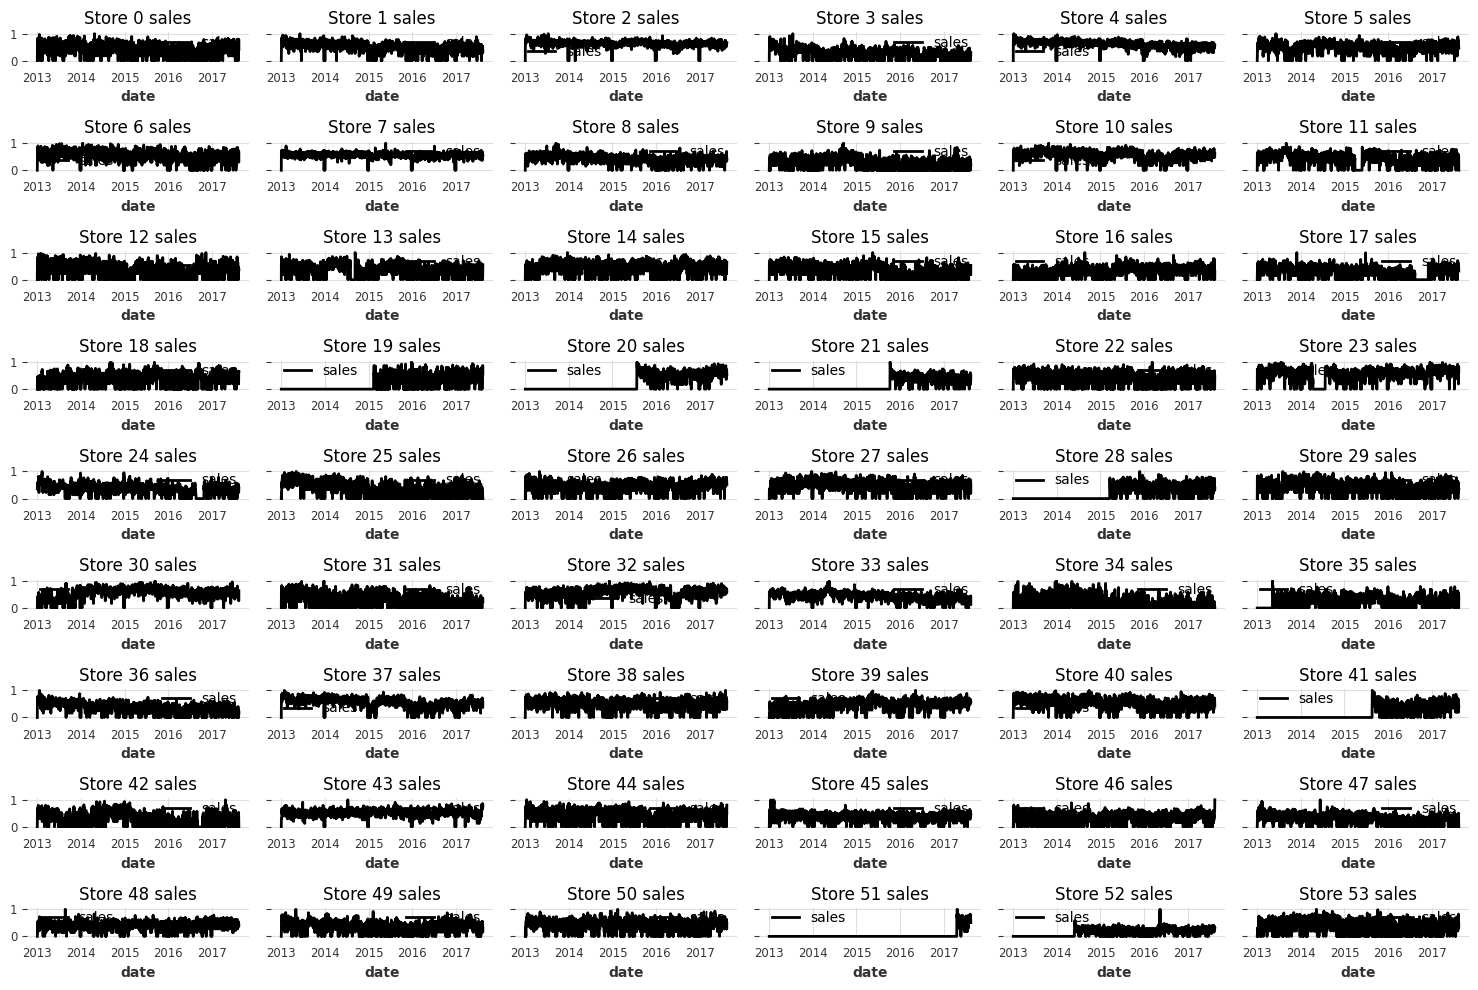

In [88]:
#plot the sales of each store for LINGERIE
plot_product_family_sales(family_ts_dict['LINGERIE'])

It seems more than half of stores have a lot of zero sales in 'LINGERIE' and many stores start to sell Lingerie in different years, like store 51 start have LINGERIE in the middle of 2017

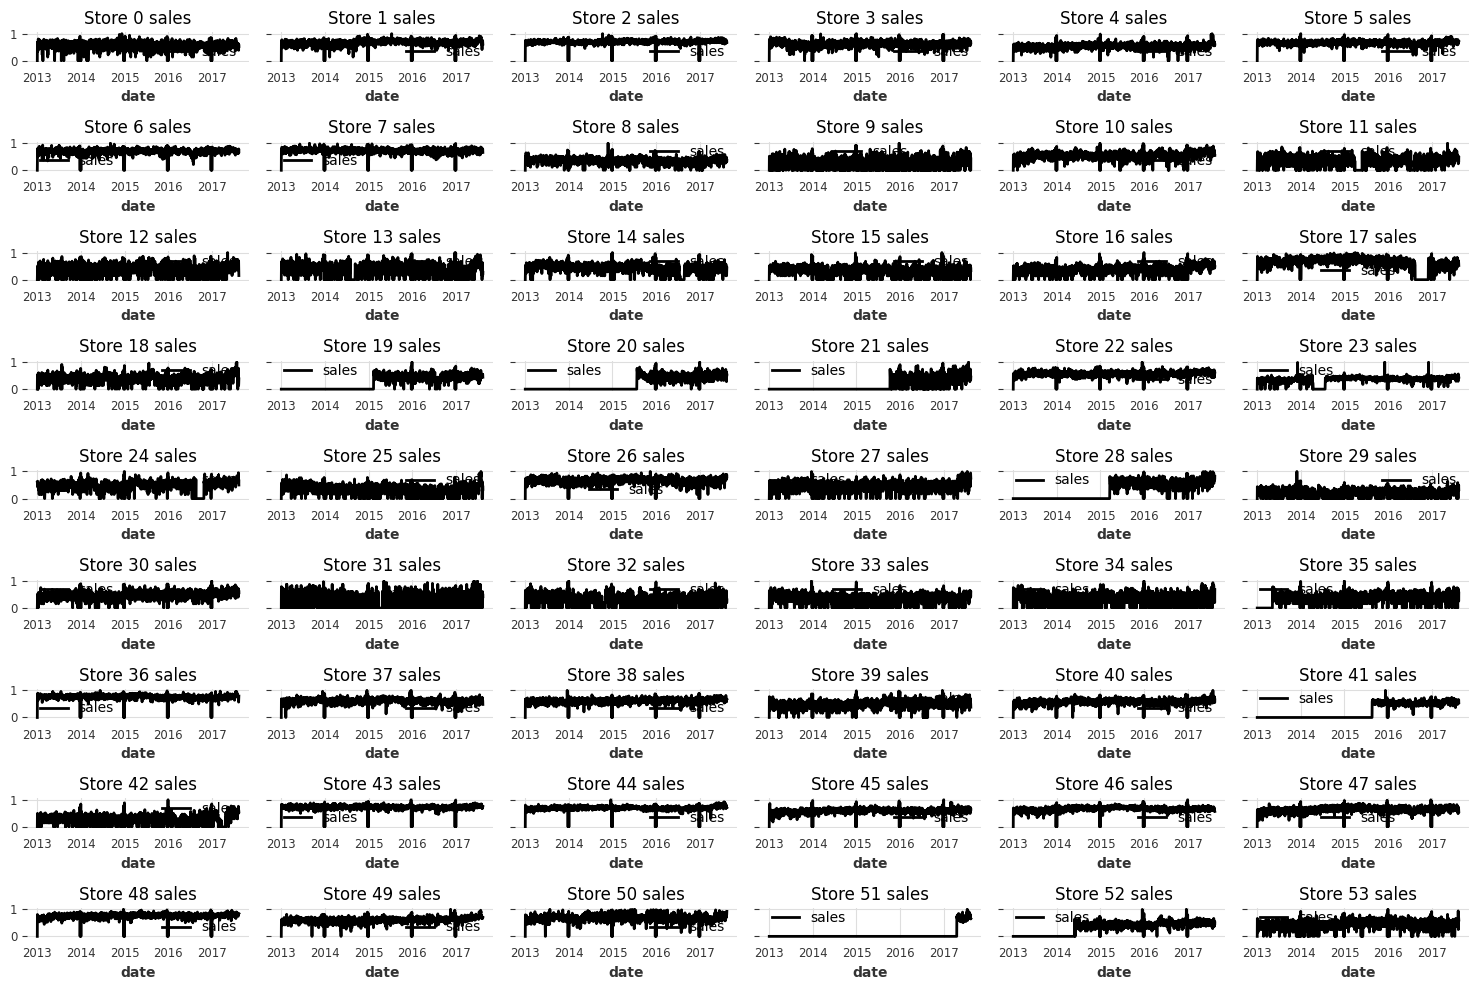

In [90]:
#plot the sales of each store for GRONCERY II
plot_product_family_sales(family_ts_dict['GROCERY II'])

Similar to LINGERIE, many stores GROCERY II have zero sales during the year

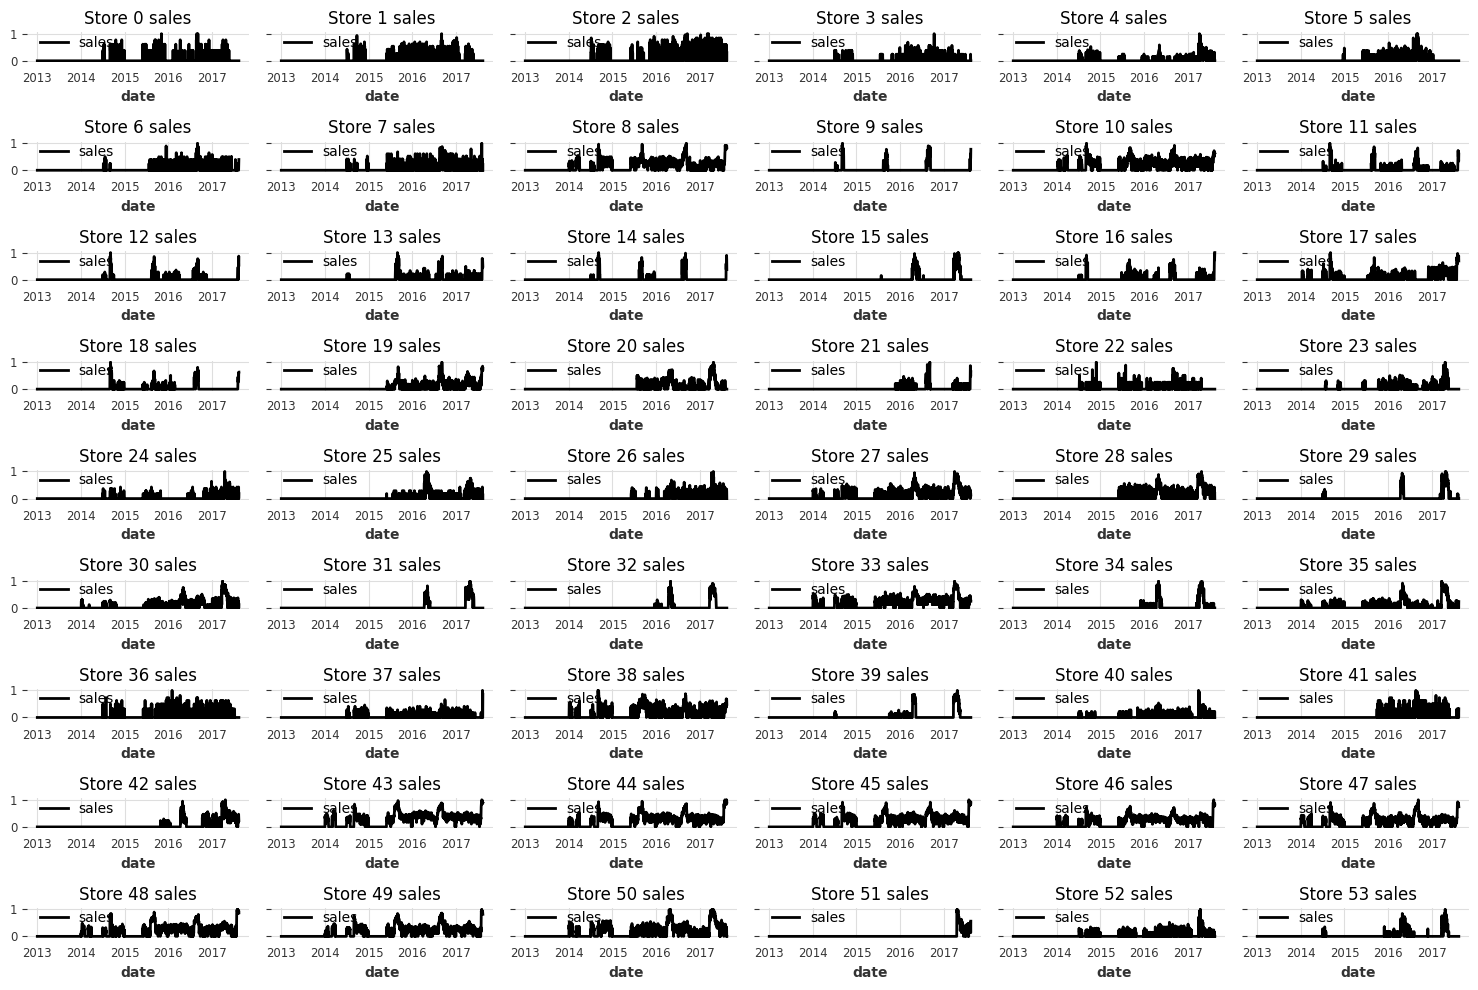

In [91]:
#plot the sales of each store for SCHOOL AND OFFICE SUPPLIES
plot_product_family_sales(family_ts_dict['SCHOOL AND OFFICE SUPPLIES'])

SCHOOL AND OFFICE SUPPLIES have both zero sales and seasonal sales characteristics

# Notes
## **Darts**
* darts TimeSeries.from_..., all functions are build a time series except from_groupdataframe which returns a list of time series
* TimeSeries.from_groupdataframe() will return your the multiplication of the length of each item in group_cols
* we could change component name by TimeSeries.with_columns_renamed(col_names=, col_names_new=)
* TimeSeries.components.values[0] returns exactly the components name
* If we are stacking multiple darts time series and do not want to have redundant covariate name, we should use TimeSeries.from_series(ts.pd_series()) to remove the covariate name
* TimeSeries.values() can check the value.  Timeseries.astype() can change the value type
* TimeSeries.stack(TimeSeries) like pd.concat([series1, series2])
* TimeSeries.static_covariates returns pd.DataFrame which contains all static_covariates


## Project steps and Customerized Functions

* Import all data which include train,test,transaction, store, oil, holidays, and submission sample
* Data processing
    * function: get_pipeline which includes missing data filler, one hot encoder(optional), min_max_normalizer, log transformer(optional)
    * Build Main Timeseries data
        * diction of 33 product family Timeseries which cover 54 stores 
        * value_cols(target): sales
        * time_col: date
        * static cols: city, state, type, cluster
        * group cols: store_nbr, family
    * Covariates
        * Future covariates
            * Holidays
                * Treat 4 holiday types('Transfer','Holiday','Bridge','Additional') all as Holiday
                * create national_holiday,earth quack, football, national event, christmas, local holiday,work day
            * Date related
                * function: get_date_covariate
                * year, month, day, week of year,day of year/week, date_index
            * Oil
                * function: get_oil_covariate
                * function: moving_averages
                * oil, oil_moving_7days, oil_moving_28days
            * Promotion
                * function: get_promotion_covariate
                * diction of 33 product  family Timeseries which cover 54 stores
                * group_cols :store_nbr, family
                * time_col : date
                * value_cols: onpromotion
            * Stacking all Future covariates
        * Past covariates
            * Transaction
                * function: get_transaction :fill transaction data, 0 if sales is 0, otherwise pd.interpolate
* Modeling
    * Class Trainer
        * def __init__
            * target_dict,
                past_covariate_list,
                future_covariate_dict,
                pipeline_dict,
                id_dict,
                sales_zero_window,
                folds,
                forecast_horizon,       
                drop_before= None,
                keep_past_covs= None,
                keep_future_covs =None
        * function setup
        * function: clip
        * function: train_test_split
        * function: get_model        
        * function: get_ts_list_forecast
        * function: get_metric
        * function: get_validation               
        * function: get_valid_plot      
        * function: get_family_product_predict
    * define submission file through function get_submision
    * Decide the parameters
        * Baseline : linear
        * Ensemble models: 
            * XGB
            * LightGBMS